In [2]:
import asrtoolkit
from asrtoolkit import wer, cer
import cv2
import io
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import numpy as np
from PIL import Image
import pytesseract
import sys
#skimage causing issues with io standard library, hence import as
from skimage import io as ioski
from skimage.color import rgb2gray
from skimage.transform import rotate, resize
import os
import re
from google.cloud import vision
#from google.cloud.vision_v1 import types
#from google.cloud.vision_v1.types import Image
from deskew import determine_skew
#from dotenv import load_dotenv, find_dotenv
#load_dotenv()
from google.cloud import storage

In [3]:
IMG_DIR = 'C:/Users/Gauri/3) PROJECTS/Image to Text'

In [4]:
sample_img = IMG_DIR +'/sample2.jpeg'

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1080 at 0x2290F17BBB0>


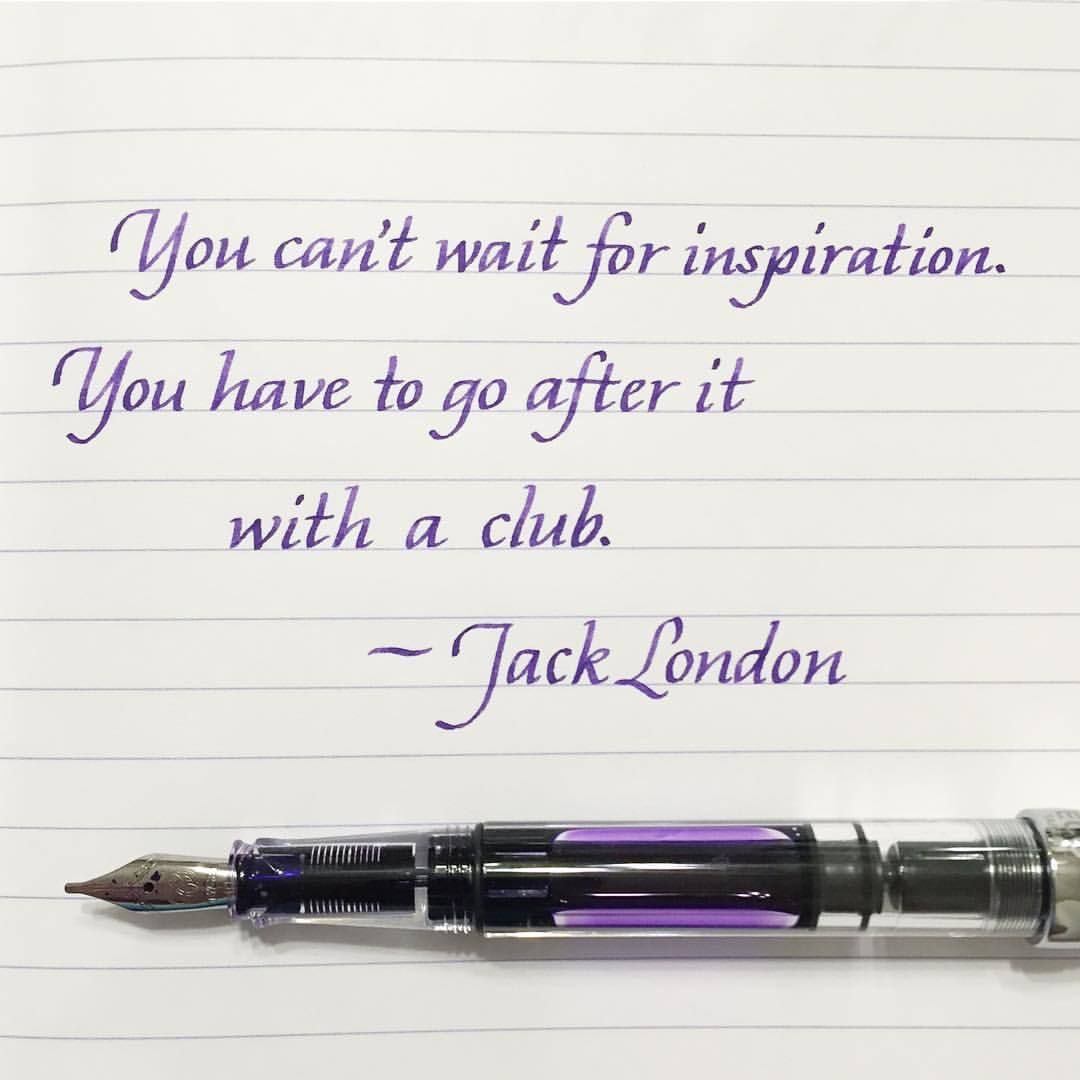

In [5]:
outputimage = Image.open(sample_img)
print(outputimage)
outputimage

In [6]:
image = ioski.imread(sample_img)
grayscale = rgb2gray(image)
angle = determine_skew(grayscale)
print(angle)
rotated = rotate(image, angle, resize=True) * 255
print(type(rotated))
ioski.imsave("output_deskewed.png", rotated.astype(np.uint8))

0.0
<class 'numpy.ndarray'>


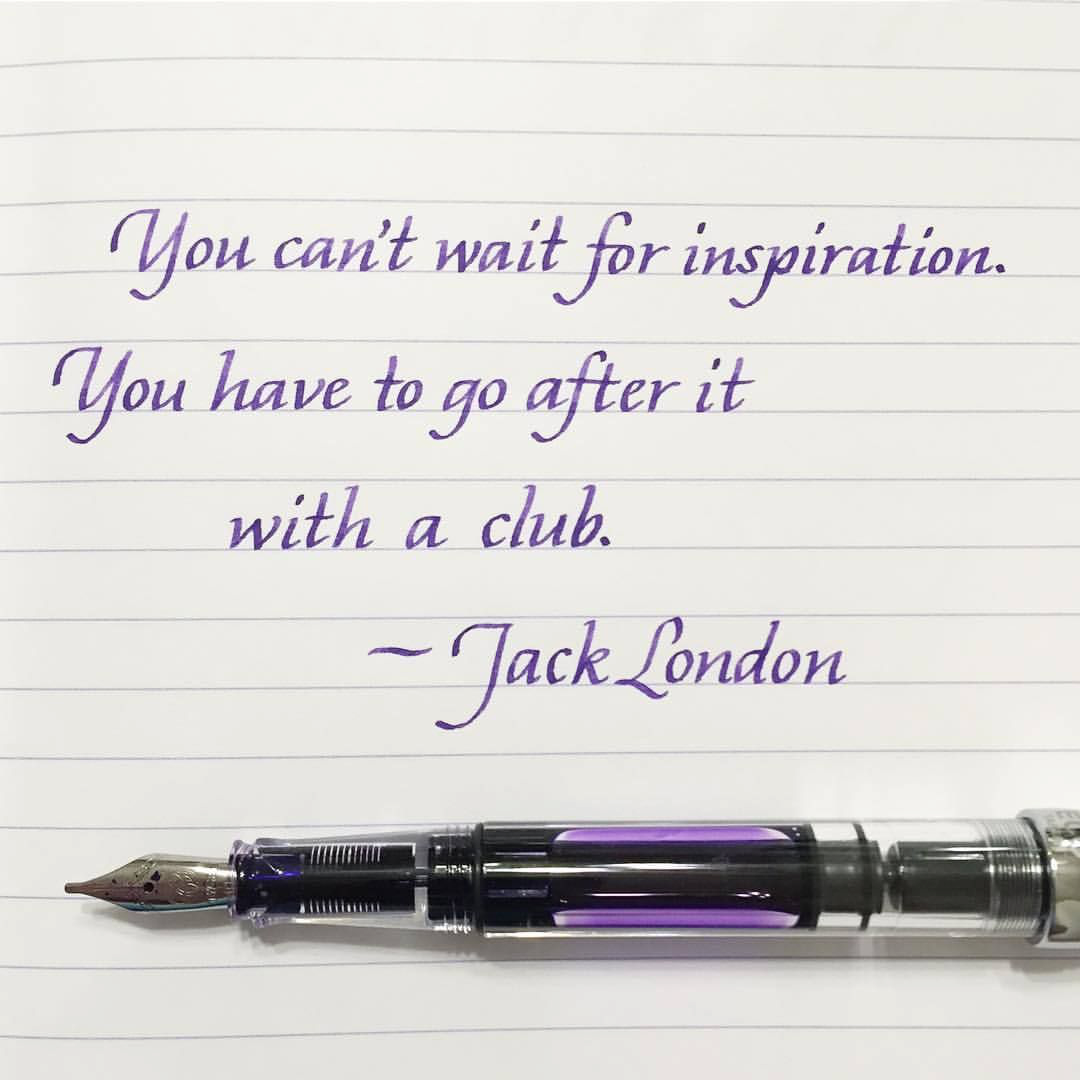

In [7]:
Image.open("output_deskewed.png")

In [8]:
def pre_process_image(image):
    """This function will pre-process a image with: cv2 & deskew
    so it can be process by tesseract"""
    img = cv2.imread(image)
    img = cv2.resize(img, None, fx=.3, fy=.3) #resize using percentage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #change color format from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #format image to gray scale
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 11) #to remove background
    return img

In [9]:
def img_process(image):
    """This function will deskew"""
    cv2output = io.imread(image)
    angle = determine_skew(cv2output)
    print("angle rotation of image",angle)
    rotated = rotate(cv2output, angle, resize=True) * 255
    return rotated

In [10]:
#use function pre_process_image to output processed image to a saved file.
processed_img = pre_process_image("output_deskewed.png")
cv2.imwrite("output_processed.png",processed_img)
processed_img = pre_process_image(sample_img)
cv2.imwrite("output_no_deskewing.png",processed_img)

True

In [11]:
ground_truth = "You can't wait for inspiration. You have to go after it with a club. ~Jack London"

In [12]:
#pytesseract no preprocessing
hypothesis0 = pytesseract.image_to_string(sample_img)
print("CER, WER, Rate :",cer(ground_truth, hypothesis0),wer(ground_truth, hypothesis0),fuzz.ratio(ground_truth, hypothesis0))
print(hypothesis0)

CER, WER, Rate : 3.7974683544303796 11.764705882352942 90
‘You can't wait for inspiration.

‘You have to go after ie
with a club.

a Jack London

 



In [13]:
#pytesseract out of the box with deskew & rgb2gray
hypothesis1 = pytesseract.image_to_string("output_deskewed.png")
print("CER, WER, Rate :",cer(ground_truth, hypothesis1),wer(ground_truth, hypothesis1),fuzz.ratio(ground_truth, hypothesis1))
print(hypothesis1)

CER, WER, Rate : 24.050632911392405 35.294117647058826 75
You can't wait for inspiration.

‘You have to go after ie
with a club.

a Jack London

-— - =.

alii

od = Ad

   

 

yout)



In [14]:
#pytesseract out of the box with preprocessing (no deskewing)
hypothesis2 = pytesseract.image_to_string("output_no_deskewing.png")
print("CER, WER, Rate :",cer(ground_truth, hypothesis2),wer(ground_truth, hypothesis2),fuzz.ratio(ground_truth, hypothesis2))
print(hypothesis2)

CER, WER, Rate : 20.253164556962027 47.05882352941177 66
You cantt.wait for inspiration.—
ou. ha we to Go. after

 

 

   

with_a_cheb__.

= "Jack i

 

 

 

 



In [15]:
#pytesseract out of the box with preprocessing w/ deskewing
hypothesis3 = pytesseract.image_to_string("output_processed.png")
print("CER, WER, Rate :",cer(ground_truth, hypothesis3),wer(ground_truth, hypothesis3),fuzz.ratio(ground_truth, hypothesis3))
print(hypothesis3)

CER, WER, Rate : 18.9873417721519 47.05882352941177 67
You cantt.wait for inspiration.—
fou. ha we to Go. after

 

 

   

with_a_cleb__.

= "Jack i

 

 

 

 



In [16]:
#pytesseract with ssq.traineddata, preprocessing
hypothesis4 = pytesseract.image_to_string("output_processed.png", lang="ssq")
print("CER, WER, Rate :",cer(ground_truth, hypothesis4),wer(ground_truth, hypothesis4),fuzz.ratio(ground_truth, hypothesis4))
print(hypothesis4)

CER, WER, Rate : 35.44303797468354 76.47058823529412 64
Ih ow con't wait for inspiration.
"You. hhan we to o afterit*[]

 

 

   

witha chh.*80"

¥w*""Jackl onJ

 

 

 

 



In [17]:
client = vision.ImageAnnotatorClient()

In [18]:
#pass the image with text(handwritten) to google vision output string
with io.open("output_processed.png",'rb') as image_file:
    content = image_file.read()

image_v = vision.Image(content=content)
response = client.document_text_detection(image=image_v)
docText = response.full_text_annotation.text
hypothesis5 = docText

print("CER, WER, Rate :",cer(ground_truth, hypothesis5),wer(ground_truth, hypothesis5),fuzz.ratio(ground_truth, hypothesis5))
print(hypothesis5)

CER, WER, Rate : 32.91139240506329 76.47058823529412 87
You can't wait for inspiration._
You have to go after it
with a club.
FORWA
WITANIAK
Jack London


In [19]:
#pass the image with text(handwritten) to google vision output string
with io.open("output_deskewed.png",'rb') as image_file:
    content = image_file.read()

image_v = vision.Image(content=content)
response = client.document_text_detection(image=image_v)
docText = response.full_text_annotation.text
hypothesis6 = docText
print("CER, WER, Rate :",cer(ground_truth, hypothesis6),wer(ground_truth, hypothesis6),fuzz.ratio(ground_truth, hypothesis6))
print(hypothesis6)

CER, WER, Rate : 7.594936708860759 17.647058823529413 94
You can't wait for inspiration.
You have to go after it
with a club.
~Jack London
FRE
